<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Differential_gene_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Differential Gene Expression Tutorial

This tutorial is intended as a simple guide for aligning and performing simple different gene expression and transcript usage.

The tutorial will answer the questions:
* Which genes are expressed in my study?
* Which genes are up-regulated in my experimental sample?
* Which gene isoforms show different patterns of abundance?
* What is the expression pattern for my favourite gene?

Methods used in this tutorial include:

* `python`: for statistical analysis and reporting,
* `minimap2`: is used to align sequence reads in a splice-aware manner against a reference transcriptome,
* `samtools`: processes the aligned reads and prepares BAM files,
* `salmon`: for defining the expressed genes and quantifying aligned reads,
* `edgeR` and `StageR`: for differential expression analysis,
* `DEXSeq`: to quantify differential transcript usage.

The computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook server.
* At least 8GB of RAM

⚠️ Warning: This notebook has been saved with its outputs for demonstration purposes. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.

## Introduction

This tutorial aims to demonstrate a workflow for long-read differential expression analysis based on cDNA sequence data. Differential gene expression (DGE) and differential transcript usage (DTU) analyses aim to identify genes and/or transcripts that show statistically (and magnitudinally) altered expression patterns in a studied biological system. The results of the differential analyses are presented in a quantitative format and therefore the degree of change (up or down regulation) between experimental conditions can be calculated for each gene identified.

These differential analyses requires a “snapshot” of gene expression that can be used to quantify the abundance of the genes’ transcripts and the relative abundance of their isoforms. In this context, abundance corresponds to the number of messenger RNAs (mRNA) measured from each gene isoform within the organism / tissue / culture being investigated. The greater the number of mRNA molecules observed from a given gene isoform, the higher its expression level. In order to determine expression levels across the whole genome, sequence data specifically targeting the mRNA molecules can be generated.

Once cDNA sequence data has been produced from both the experimental and paired control samples (with an appropriate number of biological replicates), the sequence reads can be mapped to the organism’s reference transcriptome. The number of sequences mapping to each gene isoform can be counted, and it is these count data that form the basis for the DGE and DTU analyses.

The goals from this tutorial include: 

* How a *Snakemake* workflow can be run inside EPI2ME Labs
* A basic introduction to recommended QC considerations for a sequence-based transcriptomics study
* How *TSV*-format results from *pipeline-transcriptome-de* may be opened, sorted and presented in a report
* How *MA*-plots may be prepared from TSV files and reviewed to understand the scope of transcriptional changes in a transcriptomics study
* How gene-lists prepared from TSV files may be filtered and used to present the data corresponding to genes of interest

Oxford Nanopore Technologies provides a number of sequencing solutions to allow users to generate the required snapshot of gene expression. This can be achieved by both sequencing the mRNA directly, or via a complementary DNA (cDNA) proxy. In contrast to short read sequencing technologies, entire mRNA transcripts can be captured as single reads. The example data provided with this tutorial is from a study based on the PCR-cDNA kit. This is a robust choice for performing differential transcript usage studies. This kit is suitable for preparation of sequence libraries from low mRNA input quantities. The cDNA population is enriched through PCR with low bias; an important prerequisite for the subsequent statistical analysis.

## Getting Started

To start analysing our experiment we must first set up our working directory and install software not already present in the EPI2ME Labs environment.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.

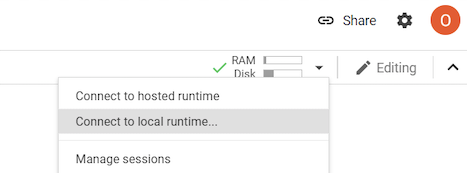

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [1]:
from epi2melabs import ping
tutorial_name = "differential-expression"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/differential-expression


In [2]:
#@markdown Tick here to show more detailed tracebacks if errors occur. 
#@markdown Default is to hide more detailed error messages
show_errors = True #@param {"type": "boolean"}

def showtraceback(*args, **kwargs):
  traceback_kwargs = {} if show_errors else {"exception_only": True}
  return oldtraceback(*args, **traceback_kwargs, **kwargs)

def checkpoint(condition, message="This step has not completed successfully"):
  assert condition, message

try:
  oldtraceback
except NameError:
  ipython = get_ipython()
  ipython.showtraceback, oldtraceback = showtraceback, ipython.showtraceback

### Install additional software

This tutorial uses a couple of software packages that are not included in the default **EPI2ME Labs** server. Below we will install these tools using the `mamba` package manager. 

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

The first piece of software we will download is our workflow code. This corresponds to the Oxford Nanopore [pipeline-transcriptome-de](https://github.com/nanoporetech/pipeline-transcriptome-de/) analysis workflow and it contains all the analysis code and logic:


In [3]:
import os

!rm -rf pipeline-transcriptome-de
!git clone --branch epi2melabs --depth 1  https://github.com/nanoporetech/pipeline-transcriptome-de.git \
    2> /dev/null \
    && cecho success "Download complete" \
    || cecho error "Download failed"

if not os.path.exists(os.path.join(working_dir, "pipeline-transcriptome-de")):
  raise Exception("Repository was not cloned successfully")

Download complete


We will install also various dependencies of the above workflow code. To do this we use `mamba`, a fast implementation of the `conda` package manager.

In [4]:
!mamba install -y -q \
    bioconductor-genomicfeatures bioconductor-drimseq bioconductor-edger \
    bioconductor-dexseq bioconductor-stager \
    snakemake salmon \
    2> /dev/null


# All requested packages already installed.



Finally we need to install a few R-language packages:

In [5]:
!Rscript -e 'install.packages("BiocManager", repos="https://ftp.fau.de/cran/")'
!Rscript -e 'BiocManager::install(c("GenomeInfoDbData", "DRIMSeq"))'

trying URL 'https://ftp.fau.de/cran/src/contrib/BiocManager_1.30.10.tar.gz'
Content type 'application/x-gzip' length 40205 bytes (39 KB)
downloaded 39 KB

* installing *source* package ‘BiocManager’ ...
** package ‘BiocManager’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BiocManager)

The downloaded source packages are in
	‘/tmp/Rtmpoaco9l/downloaded_packages’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)
Installing package(s) 'GenomeInfoDbData', 'DRIMSeq'
trying URL 'https://bioconductor.

### Sample Data

To get started we will download a set of example human control and treated reads from the pipeline github project along with the human transcriptome reference and its annotation from ensembl.

The form below will download the sample data, reference sequence and annotations. To start the download click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [6]:
#@markdown **Download sample data** *(click to show)*
experiment_name = "sample_data"
!mkdir -p $experiment_name

path = " https://media.githubusercontent.com/media/nanoporetech/ont_tutorial_transcriptome/master/RawData/"

for condition in [1, 2]:
  condition_dir = "{}/condition{}".format(experiment_name, condition)
  !mkdir -p "$condition_dir"
  names = ["condition{}_rep{}.fastq.gz".format(condition, i) for i in [1, 2, 3]]
  names = ["{}{}".format(path, name) for name in names]
  for address in names:
    !wget -P $condition_dir --no-clobber $address

ref = "http://ftp.ensembl.org/pub/release-95/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz"
annotation = "http://ftp.ensembl.org/pub/release-95/gtf/homo_sapiens/Homo_sapiens.GRCh38.95.gtf.gz"
!wget -P $experiment_name --no-clobber $ref
!wget -P $experiment_name --no-clobber $annotation

File ‘sample_data/condition1/condition1_rep1.fastq.gz’ already there; not retrieving.

File ‘sample_data/condition1/condition1_rep2.fastq.gz’ already there; not retrieving.

File ‘sample_data/condition1/condition1_rep3.fastq.gz’ already there; not retrieving.

File ‘sample_data/condition2/condition2_rep1.fastq.gz’ already there; not retrieving.

File ‘sample_data/condition2/condition2_rep2.fastq.gz’ already there; not retrieving.

File ‘sample_data/condition2/condition2_rep3.fastq.gz’ already there; not retrieving.

File ‘sample_data/Homo_sapiens.GRCh38.cdna.all.fa.gz’ already there; not retrieving.

File ‘sample_data/Homo_sapiens.GRCh38.95.gtf.gz’ already there; not retrieving.



### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

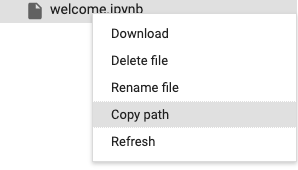

### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

Here we are editing the config file for the workflow. The datafiles will be expected to be found at the path:

```
/epi2melabs/transcriptome/{experiment_name}/{control_name}/{control_name}_rep{1,2,3}.fastq.gz
```

If you downloaded the test data this will be already set up. If you have your data in a different structure and wish to specify your 6 experimental files separately, please adjust the data in the requisite section of the config file.

In [7]:
import os
import errno
from epi2melabs import notebook
from IPython.display import display, Markdown

import aplanat
from aplanat import graphics
from aplanat import report

exec_summary = aplanat.graphics.InfoGraphItems()
report = aplanat.report.HTMLReport(
    "Differential gene expression", "EPI2ME Labs Summary")
report.markdown("## Excutive summary", key='exec-head')
report.plot(None, 'exec-plot')


def ensure_path(path, verbose=False):
    """Raise error is `path` doesn't exist"""
    if not os.path.exists(path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), path)
    elif verbose:
        print(notebook.success(f"✓ {path} exists"))
    return True


#TODO: Add functionality to check params don't contain spaces
experiment_name = "sample_data" #@param {"type": "string"}
transcriptome = "/epi2melabs/differential-expression/sample_data/Homo_sapiens.GRCh38.cdna.all.fa.gz" #@param {"type": "string"}
ensure_path(transcriptome)
annotation = "/epi2melabs/differential-expression/sample_data/Homo_sapiens.GRCh38.95.gtf.gz" #@param {"type": "string"}
ensure_path(annotation)
experiment_dir = os.path.abspath("{}/{}".format(working_dir, experiment_name))
control_name = "condition1" #@param {"type": "string"}
treated_name = "condition2" #@param {"type": "string"}

# prepare a snakemake config
import yaml
results_dir = "results"


from glob import glob

def build_sample_dict(experiment_dir, sample_name, extension=".fastq.gz"):
  wildcard = "*{}".format(extension)
  samples = glob(os.path.join(experiment_dir, sample_name, wildcard))
  return {os.path.basename(f.rstrip(extension)): f for f in samples}


extension = ".fastq.gz"
wildcard = "*{}".format(extension)
control_samples = build_sample_dict(experiment_dir, control_name)
treated_samples = build_sample_dict(experiment_dir, treated_name)

xconfig = {"pipeline": results_dir,
          "workdir_top": experiment_name,
          "resdir": "results",
          "repo": "https://github.com/nanoporetech/pipeline-transcriptome-de",
          "transcriptome": transcriptome,
          "annotation": annotation,
          "control_samples": control_samples,
          "treated_samples": treated_samples,
          "minimap_index_opts": "",
          "minimap2_opts": "",
          "maximum_secondary": 100,
          "secondary_score_ratio": 1.0,
          "salmon_libtype": "U",
          "min_samps_gene_expr": 3,
          "min_samps_feature_expr": 1,
          "min_gene_expr": 10,
          "min_feature_expr": 3,
          "threads": 50} 

all_good = True
print("Checking control samples exist...")
for path in xconfig["control_samples"].values():
    all_good &= ensure_path(path, verbose=True)
  

print("Checking treated samples exist...")
for path in xconfig["treated_samples"].values():
    all_good &= ensure_path(path, verbose=True)

if all_good:
    print()
    print("Writing new config\n")
    with open(r'config.yaml', 'w') as file:
        documents = yaml.dump(xconfig, file)
    if show_errors:
      !cat "config.yaml"
    print(notebook.success("Inputs found successfully"))
else:
    print(notebook.error("One or more inputs were invalid."))

exec_summary.append("Control replicates", len(control_samples), "calculator")
exec_summary.append("Treated replicates", len(control_samples), "calculator")


Checking control samples exist...
✓ /epi2melabs/differential-expression/sample_data/condition1/condition1_rep1.fastq.gz exists
✓ /epi2melabs/differential-expression/sample_data/condition1/condition1_rep3.fastq.gz exists
✓ /epi2melabs/differential-expression/sample_data/condition1/condition1_rep2.fastq.gz exists
Checking treated samples exist...
✓ /epi2melabs/differential-expression/sample_data/condition2/condition2_rep1.fastq.gz exists
✓ /epi2melabs/differential-expression/sample_data/condition2/condition2_rep3.fastq.gz exists
✓ /epi2melabs/differential-expression/sample_data/condition2/condition2_rep2.fastq.gz exists

Writing new config

annotation: /epi2melabs/differential-expression/sample_data/Homo_sapiens.GRCh38.95.gtf.gz
control_samples:
  condition1_rep1: /epi2melabs/differential-expression/sample_data/condition1/condition1_rep1.fastq.gz
  condition1_rep2: /epi2melabs/differential-expression/sample_data/condition1/condition1_rep2.fastq.gz
  condition1_rep3: /epi2melabs/different

If all inputs were successfully validated (and error logging has been requested) the code above will display the configuration file to used by the worflow steps below. If some input files could not be found then an error will be displayed.

## Running the analysis pipeline

With our dataset defined in the preceding section we can now begin our analysis. In this section we will walk through the steps of the analysis pipeline, describing each of the steps in turn such that the user can better understand the process and its outputs.

### Aligning reads to reference sequence

The first step of our analysis is to align both the control and treated samples to the transcriptome reference. To do this most efficiently we should first create a transcriptome reference index:

In [8]:
!snakemake --snakefile pipeline-transcriptome-de/Snakefile all \
    --configfile config.yaml -j 4 \
    --until "build_minimap_index"

Building DAG of jobs...
Nothing to be done.
Complete log: /epi2melabs/differential-expression/.snakemake/log/2020-09-04T115546.055957.snakemake.log


We can use the reference transcriptome index created in the step above to find alignments of our sequencing reads to the reference sequence:

In [9]:
!snakemake --snakefile pipeline-transcriptome-de/Snakefile all \
    --configfile config.yaml -j 4 \
    --until "map_reads"

Building DAG of jobs...
Nothing to be done.
Complete log: /epi2melabs/differential-expression/.snakemake/log/2020-09-04T115547.443474.snakemake.log


The previous step should have created a BAM format alignment file for each of the experimental and control samples. These data will be used for different statistical analyses. It is recommended to review the results from the mapping analysis before considering the statistical analysis. Let's look at the key mapping characteristics for our samples - a first step should be to extract some mapping characteristics from each of the BAM files; we will use the `seqkit` software to do this.

In [10]:
#@markdown Generate alignment stats (Click for details)
align_dir = os.path.join(experiment_dir, results_dir, "sorted_alignments")
bams = sorted((f for f in os.listdir(align_dir) if f.endswith(".bam")))

for bam in (os.path.join(align_dir, f) for f in bams):
  seqkit_stats = "{}.seqkit.tsv".format(bam)
  !seqkit bam $bam 2> "$seqkit_stats"
  checkpoint(seqkit_stats)
  !cecho success "✔ Generated tsv for $bam"

!cecho success "Step complete"

✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition1_rep1.bam
✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition1_rep2.bam
✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition1_rep3.bam
✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition2_rep1.bam
✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition2_rep2.bam
✔ Generated tsv for /epi2melabs/differential-expression/sample_data/results/sorted_alignments/condition2_rep3.bam
Step complete


Differential gene expression is sensitive to the quantity and quality of starting data. The next step in the QC assessment is to assess whether the starting sequence libraries are similar in these regards. The code block below with present the results from the `seqkit` analysis as a table. Please have a look and see whether there is equivalence in the number of sequence reads, mapped reads and quality scores.

In [11]:
#@markdown **Prepare raw read and alignment summaries for each condition** *(click for details)* 
from glob import glob
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

def parse_seqkit(fname):
    cols = {
        'Read':str, 'Ref': str, 'MapQual':int, 'Acc':float, 'ReadLen':int,
        'ReadAln':int, 'ReadCov':float, 'MeanQual':float,
        'IsSec':bool, 'IsSup':bool}
    df = pd.read_csv(fname, sep="\t", dtype=cols, usecols=cols.keys())
    df['Clipped'] = df['ReadLen'] - df['ReadAln']
    df['Type'] = 'Primary'
    df.loc[df['IsSec'], 'Type'] = 'Secondary'
    df.loc[df['IsSup'], 'Type'] = 'Supplementary'
    df["fname"] = os.path.basename(fname).rstrip(".bam.seqkit.tsv")
    return df

def create_summary_table(df):
  def number_of_alignments(df, field_name):
    grouped = df.groupby('fname').agg(**{
        field_name: ('Read', 'size'),
        })
    return grouped.transpose()

  all = number_of_alignments(df, "Read mappings")
  total_alignment_count = int(all.transpose().sum())
  exec_summary.append("Total alignments", total_alignment_count, "calculator")
  primary = number_of_alignments(df.loc[df['Type'] == 'Primary'], "Primary")
  secondary = number_of_alignments(df.loc[df['Type'] == 'Secondary'], "Secondary")
  supplementary = number_of_alignments(df.loc[df['Type'] == 'Supplementary'], "Supplementary")
  avg_acc = df.loc[df['Type'] == 'Primary'].groupby('fname').agg(**{"Median Qscore": ('MeanQual', 'median'),}).transpose()
  avg_mapq = df.loc[df['Type'] == 'Primary'].groupby('fname').agg(**{"Median MAPQ": ('MapQual', 'median'),}).transpose()
  return pd.concat(
      [
        all,
        primary,
        secondary,
        supplementary,
        avg_acc,
      avg_mapq,
      ]
  )


def pool_csvs(folder):
  files = glob(folder+"/*bam.seqkit.tsv")
  dfs = [parse_seqkit(f) for f in files]
  return pd.concat(dfs)


alignment_stats = pool_csvs(align_dir)
alignment_summary_df = create_summary_table(alignment_stats)
report.table(alignment_summary_df, key='alignment-stats')
alignment_summary_df


fname,condition1_rep1,condition1_rep2,condition1_rep3,condition2_rep1,condition2_rep2,condition2_rep3
Read mappings,29474.00,29597.00,29357.00,28541.00,27979.00,27981.00
Primary,12134.00,12253.00,12107.00,13450.00,13317.00,13283.00
Secondary,16684.00,16694.00,16570.00,14331.00,14009.00,14010.00
Supplementary,656.00,650.00,680.00,760.00,653.00,688.00
Median Qscore,8.89,8.88,8.88,8.88,8.88,8.88
Median MAPQ,17.00,18.00,18.00,50.00,51.00,50.00


### Transcript quantification

In the previous sections, cDNA sequence reads have been mapped to the reference transcriptome using minimap2. The [Salmon](https://salmon.readthedocs.io/en/latest/salmon.html) tool (Patro et al. (2017)) will now we used to assign cDNA reads to individual annotated transcripts defined by the GTF-format annotation file provided. This will be performed using the alignment-based mode of `Salmon`.

In [12]:
!snakemake --snakefile pipeline-transcriptome-de/Snakefile all \
    --configfile config.yaml -j 4 \
    --until "merge_counts"

Building DAG of jobs...
Nothing to be done.
Complete log: /epi2melabs/differential-expression/.snakemake/log/2020-09-04T115700.977201.snakemake.log


The *Salmon* analysis in the previous step has produced output files that describe the number of sequence reads assigned to each of the annotated transcripts. To simplify the exploration and analysis of these count data, the information for each of the experimental samples will be aggregated into a single file placed in the file, `merged/all_counts.tsv`.

At this point in the workflow we have used the *Salmon* tool to convert a BAM file of cDNA sequence read mappings to lists of read-counts at individual gene transcript resolution. The information from each of the experimental samples has been aggregated and we have a single TSV format file that describes the quantitative context of our biological system.

In the next section we will go on to perform a statistical analysis of this starting file to identify the annotated features that show either differential gene expression or differential transcript usage.

### Calculating differential expression

The previous section has produced a single TSV-format file that describes the number of cDNA sequence reads that correspond to each of the annotated transcripts in the provided GTF-format annotation file.  

We will now use these count data to perform a statistical analysis to identify the genes and transcripts that show differences in abundance between the experimental conditions.

#### Pre-filtering of quantitative data using *DRIMSeq*

DRIMSeq (Nowicka and Robinson (2016)) is used to filter the transcript count data from the salmon analysis. The filter step will be used to select for genes and transcripts that satisfy rules for the number of samples in which a gene or transcript must be observed and minimum threshold levels for the number of observed reads. The parameters used for filtering are defined in the config.yaml file. The parameters defined for this analysis include

*   min_samps_gene_expr = 3 - a transcript must be mapped to a gene in at least this minimum number of samples for the gene be included in the analysis 
*    min_samps_feature_expr = 1 - a transcript must be mapped to an isoform in at least this this minimum number of samples for the gene isoform to be included in the analysis
*   min_gene_expr = 10 - the minimum number of total mapped sequence reads for a gene to be considered expressed
*   min_feature_expr = 3 - the minimum number of total mapped sequence reads for a gene isoform to be considered

#### *edgeR* based differential expression analysis

A statistical analysis is first performed using edgeR (Robinson, McCarthy, and Smyth (2010), McCarthy et al. (2012)) to identify the subset of differentially expressed genes. The filtered list of gene counts is used as input. A normalisation factor is calculated for each sequence library (using the default TMM method - please see McCarthy et al. (2012) for further details). The defined experimental design is used to calculate estimates of dispersion across for each of the gene features. Genewise statistical tests are then calculated, again using the contrasts defined in the experimental design. The differentially expressed genes are corrected for false discovery (fdr) using the method of Benjamini & Hochberg (Benjamini and Hochberg (1995))

#### Differential transcript usage using *DEXSeq*

Differential transcript usage analysis is performed using the R DEXSeq package (Reyes et al. (2013)). Similar to the edgeR package, DEXSeq estimates the variance between the biological replicates and applies generalised linear models for the statistical testing. The key difference is that the DEXSeq method is looking for differences at the exon count level.

DEXSeq uses the filtered transcript count data prepared earlier in this analysis.

#### *StageR* stage-wise analysis of DGE and DTU

The final component of this cDNA sequence based gene isoform analysis is a stage-wise statistical analysis using the R software package called stageR (Van den Berge and Clement (2018)). stageR uses (1) the raw p-values for DTU from the DEXSeq analysis in the previous section and (2) a false-discovery corrected set of p-values from testing whether individual genes contain at least one exoning showing DTU. A hierarchical two-stage statistical testing evaluates the set of genes for DTU.

#### Running the analysis

The filtering and statistical tests described in the sections above can be run using a single target of the *Snakefile* used. 

In [13]:
!snakemake --snakefile pipeline-transcriptome-de/Snakefile \
    --configfile config.yaml -p -j 4 \
    --until "de_analysis"

Building DAG of jobs...
Nothing to be done.
Complete log: /epi2melabs/differential-expression/.snakemake/log/2020-09-04T115702.383948.snakemake.log


The following files are created by the above step and can be viewed outside of this notebook:

* `results_dge.pdf` - this is a summary file report of DGE results
* `results_dge.tsv` - this is a **gene**-level result file that describes genes and the probability that they show differential expression between experimental conditions (from edgeR analysis)
* `results_dtu.pdf` - this is a summary report of DTU results.
* `results_dtu_gene.tsv` - this is a **gene**-level result file from *DEXSeq* that lists annotated genes and their probabilities of differential expression
* `results_dtu_stageR.tsv` - this is the output from *StageR* and is shows both gene and transcript probabilities of differential expression
* `results_dtu_transcript.tsv`- this is a **transcript**-level result file from *DEXSeq* that lists annotated genes and their probabilities of differential expression
* `results_dexseq.tsv` - this is the complete output from the *DEXSeq*-analysis and is used to prepare some of the figures presented in this tutorial.

In the next section we will be investigating and reviewing the content from some of these files. Key data from the analysis will be presented in a graphical way to help understand the biological system and identify candidate genes. 

## Data analysis

The preceding section has walked through the execution of the differential expression analysis code. We will now use the outputs of this analysis pipeline to examine the datasets and tease out biologically meaningful observations.

#### Reviewing results from the Salmon analysis

In the Snakemake workflow the *Salmon* software was used to link mapped cDNA sequence reads to their corresponding annotated transcripts. Within the differential expression analysis the Salmon results (one per sample) were aggregated into a single file. Let's have a look at this file and review some of the more abundant transcripts identified.

The code block below will import the aggregated results from the TSV file prepared and will sort the transcripts by abundance (total reads across all samples) before printing the top 10 transcripts characterised. These are the primary data that are passed on to the subsequent statistical tests.

In [14]:
#@markdown **Displaying results** *(Click to show code)*
import pandas as pd
import numpy as np

salmon_merged_file = filtered_count_file = f"{experiment_name}/{results_dir}/merged/all_counts.tsv"
salmon_counts = pd.read_csv(salmon_merged_file, sep='\t')
salmon_counts.set_index("Reference", drop=True, append=False, inplace=True)
salmon_size_top = salmon_counts.sum(axis=1).sort_values(ascending=False)

salmon_counts = salmon_counts.applymap(np.int64)
display(salmon_counts.loc[salmon_size_top.index].head(n=10))
salmon_count_caption = '''*Table showing the 10 annotated transcript features
identified by Minimap2 mapping and Salmon transcript detection with the highest
number of mapped reads*'''

display(Markdown(salmon_count_caption))
report.markdown(salmon_count_caption, "salmon-head-caption")
report.table(salmon_counts.loc[salmon_size_top.index].head(n=10), "salmon-head")

unique_transcripts = int(salmon_counts.reset_index()["Reference"].size)
exec_summary.append("Unique transcripts found", unique_transcripts, "calculator")

,condition1_rep1,condition1_rep2,condition1_rep3,condition2_rep1,condition2_rep2,condition2_rep3
Reference,,,,,,
ENST00000367816.5,1677,1674,1690,3879,3872,3902
ENST00000321358.11,881,914,923,527,543,505
ENST00000290541.6,368,348,333,209,192,194
ENST00000368926.5,410,397,385,126,121,122
ENST00000648638.1,238,218,253,292,255,276
ENST00000263168.3,227,229,221,161,193,176
ENST00000436427.1,196,205,180,194,206,185
ENST00000545882.5,231,226,218,123,95,145
ENST00000629042.2,241,253,261,81,75,80


*Table showing the 10 annotated transcript features
identified by Minimap2 mapping and Salmon transcript detection with the highest
number of mapped reads*

The *Salmon* method has assigned reads to transcripts. It is recommended to have a quick check of the number of transcripts that are assigned to individual genes. It is anticipated that a majority of genes will be associated with a single transcript; it is the population of genes containing two or more transcripts that have been assessed for differential transcript usage.

To plot the number of transcripts per gene we need to open two files from the merged output results. The file `merged/all_counts_filtered.tsv` contains the input data for the **stageR** analysis and contains the mappings and read counts for genes associated multiple-transcripts. `merged/all_gene_counts.tsv` contains all gene-level counts and can be used to identify the genes associated with a single transcript.

The code-block below processes the data from these two files to prepare a histogram showing the abundance of transcript counts for genes identified in the analysis.



In [15]:
#@markdown **Review the number of transcripts per gene** *(Click to show code)*
filtered_count_file = f"{experiment_name}/{results_dir}/merged/all_counts_filtered.tsv"
# note that filtered_counts only includes genes with > 1 transcript
transcripts_per_gene = pd.read_csv(filtered_count_file, \
                                   sep='\t', \
                                   usecols=['gene_id', 'feature_id']).groupby(['gene_id']).agg(['count'])
transcripts_per_gene.columns = transcripts_per_gene.columns.droplevel()
# now load the complete genes counts
gene_count_file = f"{experiment_name}/{results_dir}/merged/all_gene_counts.tsv"
gene_ids = pd.read_csv(gene_count_file, \
                                   sep='\t', \
                                   usecols=[0]).index.values.tolist()
# identify the singletons
singletons = [ gene_id for gene_id in gene_ids if not gene_id in transcripts_per_gene.index.values.tolist()] 
singletons = pd.DataFrame(index=singletons, columns=['count']).fillna(1)
# and add the singletons to transcripts_per_gene
transcripts_per_gene = pd.concat([singletons, transcripts_per_gene])

### PLEASE DELETE ME BEFORE RELEASE ###
gene_transcript_counts = transcripts_per_gene.apply(pd.value_counts)
groups = gene_transcript_counts.index.to_numpy()
# print(groups)
counts = gene_transcript_counts['count'].to_numpy()
# print(counts)
### PLEASE DELETE ME BEFORE RELEASE ###

import aplanat
from aplanat import hist
plot = hist.histogram([transcripts_per_gene['count'].tolist()], binwidth=1)
plot.xaxis.axis_label = "Number of transcripts per gene (n)"
plot.yaxis.axis_label = "Number of occurences"
aplanat.show(plot)
transcripts_per_gene_caption = """Histogram showing the abundance of 
transcript counts for genes identified in the analysis.
"""
report.markdown(transcripts_per_gene_caption, "transcripts-per-gene-caption")
report.plot(plot, "transcripts-per-gene")
display(Markdown(transcripts_per_gene_caption))

Histogram showing the abundance of 
transcript counts for genes identified in the analysis.


### Differential Gene Expression (DGE)
The following analysis will focus on the data found in the output file named `results_dge.tsv` from the analysis pipeline. Similar plots to those produced below are also presented in `results_dge.pdf` report file from the pipeline.


In [16]:
#@markdown **Top 15 genes ranked by adjusted p-value from the edgeR analysis** *(Click for code)*
import pandas as pd
import numpy as np

pd.reset_option('display.float_format')

dge_file = filtered_count_file = f"{experiment_name}/{results_dir}/de_analysis/results_dge.tsv"
dge_results = pd.read_csv(dge_file, sep='\t')

dge_pvals = dge_results.sort_values(by='FDR', ascending=True)

dge_results[['logFC', 'logCPM', 'F']] = dge_results[['logFC', 'logCPM', 'F']].round(2)
display(dge_results.loc[dge_pvals.index].head(n=15))

# include a legend
dge_caption = '''*Table showing the top 15 genes, ranked by adjusted p-value, 
from the edgeR analysis. Information shown includes the log2 fold change between
experimental conditions, the log-scaled counts per million measure of abundance
and the false discovery corrected p-value (FDR). This table has not been
filtered for genes that satisfy statistical or magnitudinal thresholds*'''
display(Markdown(dge_caption))
report.table(dge_results.loc[dge_pvals.index].head(n=15), "dge-table")
report.markdown(dge_caption, "dge-caption")


,logFC,logCPM,F,PValue,FDR
ENSG00000143153,-1.32,17.77,9503.62,9.848433e-11,1.018328e-07
ENSG00000168679,-6.39,12.21,2661.96,4.270058e-09,2.207620e-06
ENSG00000143443,1.59,14.36,1877.68,1.199131e-08,4.133004e-06
ENSG00000143401,1.50,13.87,1462.06,2.512218e-08,6.179591e-06
ENSG00000213625,-2.43,13.19,1378.67,2.988197e-08,6.179591e-06
ENSG00000143320,3.57,11.54,988.46,7.979872e-08,1.375198e-05
ENSG00000117523,11.60,13.99,8163.22,1.141308e-07,1.685875e-05
ENSG00000169905,10.54,12.95,5245.72,2.720549e-07,3.516309e-05
ENSG00000160679,2.30,10.58,424.15,9.608743e-07,1.103938e-04
ENSG00000126709,-1.64,11.56,404.59,1.103304e-06,1.140817e-04


*Table showing the top 15 genes, ranked by adjusted p-value, 
from the edgeR analysis. Information shown includes the log2 fold change between
experimental conditions, the log-scaled counts per million measure of abundance
and the false discovery corrected p-value (FDR). This table has not been
filtered for genes that satisfy statistical or magnitudinal thresholds*

The results from the edgeR analysis can be plotted as an MA Plot. This plot visualises differences in measurements between the two experimental conditions. M is the log2 ratio of gene expression calculated between the conditions. A is a log2 transformed mean expression value. The figure below presents the MA figure from this edgeR analysis. Genes that satisfy the logFC and FDR corrected p-value thresholds defined are shaded as **'Up-'** or **'Down-'** regulated.

In [17]:
#@markdown **Differential counts** *(click to show)*
#TODO: Needs a key and the limit y lines and also a lower weight for the non-significant points

import aplanat
import pandas as pd
from aplanat import points

dge = "/epi2melabs/{}/{}/{}/" \
    "de_analysis/results_dge.tsv".format(
        tutorial_name, experiment_name, results_dir)
dge = pd.read_csv(dge, sep="\t")
pval_limit = 0.01
up = dge.loc[(dge["logFC"] > 0) & (dge['PValue'] < pval_limit)]
down = dge.loc[(dge["logFC"] <= 0) & (dge['PValue'] < pval_limit)]
not_sig = dge.loc[(dge["PValue"] >= pval_limit)]
logcpm_vs_logfc = points.points(
    x_datas=[
             up["logCPM"], 
             down["logCPM"], 
             not_sig["logCPM"],
             ], 
    y_datas=[
             up["logFC"], 
             down["logFC"],
             not_sig["logFC"],
             ],
    title="Average copy per million (CPM) vs Log-fold change (LFC)",
    colors=["blue", "red", "black"],
    names=["Up", "Down", "NotSig"]
    )

logcpm_vs_logfc.xaxis.axis_label = "Average log CPM"
logcpm_vs_logfc.yaxis.axis_label = "Log-fold change"
aplanat.show(logcpm_vs_logfc)
logcpm_caption = """Results of the edgeR Analysis"""
report.plot(logcpm_vs_logfc, "logcpm-vs-log-fc")
report.markdown(logcpm_caption)
display(Markdown(logcpm_caption))


Results of the edgeR Analysis

### Differential Transcript Usage

Differential transcript usage analysis is performed using the R **DEXSeq** package (Reyes et al. (2013)). Similar to the **edgeR** package, **DEXSeq** estimates the variance between the biological replicates and applies generalised linear models for the statistical testing. The key difference is that the **DEXSeq** method is looking for differences at the exon count level.

DEXSeq uses the filtered transcript count data prepared earlier in this analysis - let's have a quick look at the results described in the file `de_analysis/results_dtu_transcript.tsv`.




In [18]:
#@markdown **Top 15 genes ranked by adjusted p-value from the DEXSeq analysis** *(click to show code)* 
import pandas as pd
import numpy as np

dexseq_file = filtered_count_file = f"{experiment_name}/{results_dir}/de_analysis/results_dexseq.tsv"
dexseq_results = pd.read_csv(dexseq_file, sep='\t')
dexseq_pvals = dexseq_results.sort_values(by='pvalue', ascending=True)

display(dexseq_results.loc[dexseq_pvals.index].head(n=15))
report.table(dexseq_results.loc[dexseq_pvals.index].head(n=15), "dexseq-head")
dexseq_caption = '''*Table showing the top 15 gene isoforms, ranked by adjusted 
p-value, from the DEXSeq analysis. Information shown includes the log2 fold 
change between experimental conditions, the log-scaled transcript abundance and 
the false discovery corrected p-value (FDR). This table has not been filtered 
for genes that satisfy statistical or magnitudinal thresholds*'''
display(Markdown(dexseq_caption))
report.markdown(dexseq_caption, "dexseq-head-caption")

,Log2MeanExon,Log2FC,pvalue,padj
ENSG00000143442:ENST00000271715,2.813474,-17.709932,3.145616e-23,1.198480e-20
ENSG00000085832:ENST00000371730,3.785937,-16.286305,1.474326e-22,2.808590e-20
ENSG00000085832:ENST00000371733,2.821409,14.871998,2.147509e-19,2.635157e-17
ENSG00000132849:ENST00000484937,2.383466,1.330886,2.766569e-19,2.635157e-17
ENSG00000126709:ENST00000339145,4.764516,-12.158246,9.475282e-17,7.220165e-15
ENSG00000126709:ENST00000361157,3.109135,21.176774,1.503898e-16,9.549751e-15
ENSG00000160752:ENST00000368356,2.967874,15.238805,6.321788e-16,3.440859e-14
ENSG00000143442:ENST00000368863,3.801362,13.925323,1.813391e-15,8.636275e-14
ENSG00000160752:ENST00000467076,2.402474,-16.955405,3.294748e-15,1.394777e-13
ENSG00000127125:ENST00000372561,4.061966,0.265387,1.302628e-13,4.526926e-12


*Table showing the top 15 gene isoforms, ranked by adjusted 
p-value, from the DEXSeq analysis. Information shown includes the log2 fold 
change between experimental conditions, the log-scaled transcript abundance and 
the false discovery corrected p-value (FDR). This table has not been filtered 
for genes that satisfy statistical or magnitudinal thresholds*

The results from the DEXSeq analysis can also be plotted as an MA Plot. MA-plots are described in the previous section on `edgeR` data review. As a brief reminder, M is the log2 ratio of transcript abundance between conditions. A is the log2 transformed mean abundance value. The figure below presents the MA plot from the `DEXSeq` analysis. Transcripts that satisfy the logFC and FDR corrected p-value thresholds defined are shaded as 'Up-' or 'Down-' regulated.

In [19]:
#@markdown **Further dexseq results** *(click to show code)*
import aplanat
import pandas as pd
from aplanat import points

pval_limit = 0.01
up = dexseq_results.loc[(dexseq_results["Log2FC"] > 0) & (dexseq_results['pvalue'] < pval_limit)]
down = dexseq_results.loc[(dexseq_results["Log2FC"] <= 0) & (dexseq_results['pvalue'] < pval_limit)]
not_sig = dexseq_results.loc[(dexseq_results["pvalue"] >= pval_limit)]

plot = points.points(
    x_datas=[
             up["Log2MeanExon"], 
             down["Log2MeanExon"], 
             not_sig["Log2MeanExon"],
             ], 
    y_datas=[
             up["Log2FC"], 
             down["Log2FC"],
             not_sig["Log2FC"],
             ],
    title="Average copy per million (CPM) vs Log-fold change (LFC)",
    colors=["red", "blue", "black"],
    xlim = [0, 5],
    names=["Up", "Down", "NotSig"]
    )

# plot = points.points(x_datas=[dexseq_results["Log2MeanExon"]], y_datas=[dexseq_results["Log2FC"]], xlim=[0, 5])
plot.xaxis.axis_label = "A (log2 transformed mean exon read counts)"
plot.yaxis.axis_label = "M (log2 transformed differential abundance)"
aplanat.show(plot)
dexseq_results_caption = "dexseq results"
display(Markdown(dexseq_results_caption))
report.markdown(dexseq_results_caption)
report.plot(plot)

dexseq results

### StageR analysis

The final component of this cDNA sequence based gene isoform analysis is a stage-wise statistical analysis using the R software package called stageR (Van den Berge and Clement (2018)). **StageR** uses (1) the raw p-values for DTU from the **DEXSeq** analysis in the previous section and (2) a false-discovery corrected set of p-values from testing whether individual genes contain at least one exoning showing DTU. A hierarchical two-stage statistical testing evaluates the set of genes for DTU.

We can present the results from the **StageR** analysis by loading the file `de_analysis/results_dtu_stageR.tsv` - the results displayed are sorted by the probability that the gene shows differential expression.

In [20]:
#@markdown **stageR Results** *(Click to show code)*
import pandas as pd
import numpy as np

dtu_file = filtered_count_file = f"{experiment_name}/{results_dir}/de_analysis/results_dtu_stageR.tsv"
dtu_results = pd.read_csv(dtu_file, sep='\t')
dtu_pvals = dtu_results.sort_values(by='gene', ascending=True)

display(dtu_results.loc[dtu_pvals.index].head(n=10))

# include a legend
dtu_caption = '''Table showing gene and transcript identifiers and their FDR 
corrected probabilities for the genes and their isoforms that have been 
identified as showing DTU using the R packages DEXSeq and StageR. This list has 
been shortened requiring that both gene and transcript must satisfy the p-value 
threshold'''
display(Markdown(dtu_caption))
report.table(dtu_results.loc[dtu_pvals.index].head(n=10), "dtu-head")
report.markdown(dtu_caption, "dtu-caption")

dtu_pvals.astype({"gene": "int"})

,geneID,txID,gene,transcript
231,ENSG00000132849,ENST00000613764,0.0,2.894007e-12
83,ENSG00000143442,ENST00000450842,0.0,8.902381e-02
84,ENSG00000143442,ENST00000271715,0.0,9.856265e-23
228,ENSG00000132849,ENST00000484937,0.0,1.300288e-18
229,ENSG00000132849,ENST00000459752,0.0,4.302434e-08
230,ENSG00000132849,ENST00000484562,0.0,7.108051e-04
82,ENSG00000143442,ENST00000485040,0.0,1.687110e-01
150,ENSG00000085832,ENST00000371733,0.0,3.364430e-19
151,ENSG00000085832,ENST00000371727,0.0,5.143824e-02
152,ENSG00000085832,ENST00000371730,0.0,2.309777e-22


Table showing gene and transcript identifiers and their FDR 
corrected probabilities for the genes and their isoforms that have been 
identified as showing DTU using the R packages DEXSeq and StageR. This list has 
been shortened requiring that both gene and transcript must satisfy the p-value 
threshold

,geneID,txID,gene,transcript
231,ENSG00000132849,ENST00000613764,0,2.894007e-12
83,ENSG00000143442,ENST00000450842,0,8.902381e-02
84,ENSG00000143442,ENST00000271715,0,9.856265e-23
228,ENSG00000132849,ENST00000484937,0,1.300288e-18
229,ENSG00000132849,ENST00000459752,0,4.302434e-08
...,...,...,...,...
53,ENSG00000116288,ENST00000338639,0,NaN
188,ENSG00000116183,ENST00000367662,0,NaN
187,ENSG00000116183,ENST00000486075,0,NaN
39,ENSG00000143320,ENST00000368222,1,NaN


### Review of candidate genes
The tables and MA-plots presented in the previous sections have extracted genes and transcripts of interest from the `pipeline-transcriptome-de` results files. This section is used to assess and present the quantitative information produced by the workflow for *a priori* known genes-of-interest.

For searching for a gene of interest we need to know the gene identifier used within the GTF annotation file. Please use this identifier in the form below to further explore the data.

The code will prepare a table summarising the transcripts associated with the specified gene, along with read counts and the probability results from the `stageR` analysis. The transcript count data will be additionally plotted as a boxplot.

In [21]:
#@markdown Please select a gene name to see detailed gene specific information. *(Click to show code)*
# gene_id = "ENSG00000142937" #@  {"type": "string"}
gene_id = "ENSG00000132849" #@param {"type": "string"}

table = dtu_results.loc[(dtu_results["geneID"] == gene_id)]
msg = "Gene ID \"{}\" does not exist in the dataset, please select another"
assert not table.empty, msg.format(gene_id)

alignment_stats[alignment_stats["Ref"].isin([gene_id])]
alignment_stats["Transcript"] = alignment_stats["Ref"].apply(lambda x: x.split(".")[0])
gene_alignments = alignment_stats[alignment_stats["Transcript"].isin(table["txID"])]
gene_alignments = gene_alignments.loc[(gene_alignments["Type"] == "Primary")]
gene_alignments["condition"] = gene_alignments.apply(lambda x: control_name if x["fname"] in control_samples else treated_name, axis=1)
groups = gene_alignments.groupby(
    ["Transcript", "fname", "condition"]).agg(**{"Transcript_count": ("Read", "size")})

df = None
for gene_id, group in gene_alignments.groupby("Transcript"):
  temp = group.groupby("fname").agg(**{
      gene_id: ("Read", "size")
  }).transpose()
  if df is None:
    df = temp
  else:
    df = pd.concat([df, temp])

df = df.reset_index().rename(columns={"index": "Transcript_ID"})
table = table.rename(columns={
    "txID": "Transcript_ID",
    "gene": "p_gene",
    "transcript": "p_transcript"
    })
gene_table = pd.merge(df, table)
gene_table = gene_table.set_index(["geneID","Transcript_ID"])
file_names = set(control_samples.keys())
file_names.update(treated_samples.keys())
gene_table = gene_table.fillna(0)
gene_table = gene_table.astype({f: "int64" for f in file_names})


display(gene_table)
report.table(gene_table, "transcript-counts-by-condition")

candidate_gene_caption = '''Table showing a selected annotated
gene and its isoform transcripts. The number of reads mapped 
to each transcript is shown along withthe FDR corrected p-values 
for DGE and DTU. The read counts are the raw counts. '''
display(Markdown(candidate_gene_caption))


table = groups.reset_index()[["condition", "Transcript", "Transcript_count"]]
table['transcript, condition'] = \
    table['Transcript'].astype(str) + ', ' + table['condition'].astype(str)
repeats = groups.groupby(level=['Transcript', 'condition']).size()
min_rep, max_rep = min(repeats), max(repeats)

from aplanat.bars import boxplot_series
plot = boxplot_series(
    table['transcript, condition'], table['Transcript_count'],
    x_axis_label='Transcript, condition',
    y_axis_label='Transcript count',
    height=400, title="Transcript counts (from {}-{} replicates)".format(min_rep, max_rep))
plot.xaxis.major_label_orientation = 3.1452/2
if min_rep < 7:
    for renderer in plot.renderers:
        renderer.glyph.line_alpha = 0.2
        try:
            renderer.glyph.fill_alpha = 0.2
        except:
            pass
    plot.circle(
        table['transcript, condition'], table['Transcript_count'],
        fill_color='black', line_color='black')
aplanat.show(plot)
report.plot(plot, "Transcript-count-boxplot")


condition1_rep1  condition1_rep2  \
geneID          Transcript_ID                                       
ENSG00000132849 ENST00000459752                3                4   
                ENST00000484562                3                2   
                ENST00000484937                7                8   
                ENST00000613764                0                0   
                ENST00000646453                0                0   

                                 condition1_rep3  condition2_rep2  \
geneID          Transcript_ID                                       
ENSG00000132849 ENST00000459752                3                1   
                ENST00000484562                3                5   
                ENST00000484937                7               51   
                ENST00000613764                0                2   
                ENST00000646453                0                9   

                                 condition2_rep3  condition2_rep1  p_gene  \
geneID          Transcript_ID                                               
ENSG00000132849 ENST00000459752                3                0     0.0   
                ENST00000484562                3                4     0.0   
                ENST00000484937               40               52     0.0   
                ENST00000613764                2                3     0.0   
                ENST00000646453                9               15     0.0   

                                 p_transcript  
geneID          Transcript_ID                  
ENSG00000132849 ENST00000459752  4.302434e-08  
                ENST00000484562  7.108051e-04  
                ENST00000484937  1.300288e-18  
                ENST00000613764  2.894007e-12  
                ENST00000646453  2.798294e-08

Table showing a selected annotated
gene and its isoform transcripts. The number of reads mapped 
to each transcript is shown along withthe FDR corrected p-values 
for DGE and DTU. The read counts are the raw counts. 

## Headline numbers

As a final summary of the experiment the infographic below displays a small set of headline numbers captured through the course of the analysis:

In [22]:
#@markdown **Executive summary**
pinger.send_notebook_ping('stop', tutorial_name)
import aplanat.graphics

exec_plot = aplanat.graphics.infographic(exec_summary.values(), ncols=3)
aplanat.show(exec_plot)
report.plot(exec_plot, key='exec-plot')

fname = os.path.join(experiment_dir, 'report.html')
report.write(fname)
print("Report written to: {}.".format(fname))

Report written to: /epi2melabs/differential-expression/sample_data/report.html.


## Summary

In this tutorial we have used the `pipeline-transcriptome-de` workflow to analyse sequence data from a replicated cDNA sequencing study to look for genes showing differential expression and trancripts showing differential transcript usage between experimental conditions.


*   cDNA sequences have been mapped to the reference transcriptome using `minimap2`; `samtools` has been used to prepare a sorted and indexed BAM file suitable for further analysis.
*   We have reviewed the mapping characteristics for all the samples used in our study and have hopefully established that the samples included in the design are largely equivalent.
*   `Salmon` has been used to prepare transcript counts from the transcriptome mapping data and the provided GTF-format annotation file. The count data from `Salmon` has been assessed for differential expression using `edgeR`, for differential transcript usage using `DEXSeq` and a combined analysis using `StageR`.
*   We have reviewed the CSV-format result files from each of the statistical analyses above and have prepared tabular data showing lists of top genes and transcripts - the data has been presented as MA-plots to present the overall structure of the data.
*   A simple method has been implemented to present summary data for genes of interest - a summary report has been prepared and written to an HTML file for offline review. 


The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)


## References

Benjamini, Yoav, and Yosef Hochberg. 1995. “Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing.” Journal of the Royal Statistical Society. Series B (Methodological) 57 (1): 289–300. http://www.jstor.org/stable/2346101.

McCarthy, Davis J., Chen, Yunshun, Smyth, and Gordon K. 2012. “Differential Expression Analysis of Multifactor Rna-Seq Experiments with Respect to Biological Variation.” Nucleic Acids Research 40 (10): 4288–97.

Nowicka, Malgorzata, and Mark D. Robinson. 2016. “DRIMSeq: A Dirichlet-Multinomial Framework for Multivariate Count Outcomes in Genomics [Version 2; Referees: 2 Approved].” F1000Research 5 (1356). https://doi.org/10.12688/f1000research.8900.2.

Patro, Robert, Geet Duggal, Michael I Love, Rafael A Irizarry, and Carl Kingsford. 2017. “Salmon Provides Fast and Bias-Aware Quantification of Transcript Expression.” Nature Methods 14 (March). https://doi.org/10.1038/nmeth.4197.

Robinson, Mark D, Davis J McCarthy, and Gordon K Smyth. 2010. “EdgeR: A Bioconductor Package for Differential Expression Analysis of Digital Gene Expression Data.” Bioinformatics 26 (1): 139–40.
